/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.549400,0.316840
2,0.534400,0.316844
3,0.457700,0.319209
4,0.421900,0.320108
5,0.536200,0.321120
6,0.496600,0.321733
7,0.491400,0.325170
8,0.511900,0.325433
9,0.532200,0.326397
10,0.443700,0.327324


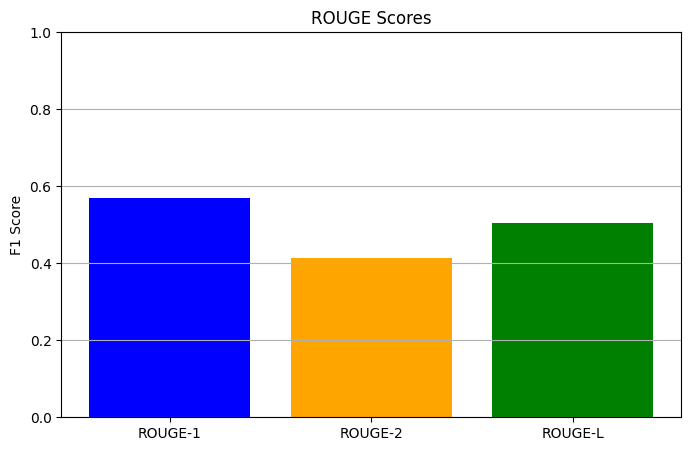

In [12]:
import torch
from datasets import load_dataset
from transformers import MT5ForConditionalGeneration, MT5Tokenizer, Trainer, TrainingArguments
import evaluate
import matplotlib.pyplot as plt

# GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
model_name = "fine_tuned_ozcangundes/mt5-small-turkish-summarization"
model = MT5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = MT5Tokenizer.from_pretrained(model_name, model_max_length=512)

model.to(device)

# 1. Load the dataset in JSON format
def load_custom_dataset(json_file):
    dataset = load_dataset('json', data_files=json_file)
    return dataset

# 2. Data processing (Tokenization)
def preprocess_function(examples):
    inputs = examples['input_text']
    targets = examples['output_text']
    
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Load and prepare the dataset
dataset = load_custom_dataset("textImprove-io.json")
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# 3. Split the training and validation datasets
train_test_split = tokenized_datasets["train"].train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

# 4. Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
)

# 5. Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

# 6. Start training
trainer.train()

# 7. Load ROUGE metric
rouge_metric = evaluate.load("rouge")

# 8. Model evaluation (corrected version)
def evaluate_model():
    model.eval()  # Set model to evaluation mode
    predictions = []
    references = []
    
    # Evaluate in batches to avoid mismatch issues
    for i in range(0, len(eval_dataset), training_args.per_device_eval_batch_size):
        batch = eval_dataset[i:i + training_args.per_device_eval_batch_size]
        
        inputs = tokenizer(batch['input_text'], return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            output_sequences = model.generate(input_ids=inputs["input_ids"], max_new_tokens=50)
        
        # Store outputs and references
        predicted_texts = [tokenizer.decode(seq, skip_special_tokens=True) for seq in output_sequences]
        references.extend(batch['output_text'])  # Actual texts
        predictions.extend(predicted_texts)  # Model predictions
    
    # Check if predictions and references match in length
    if len(predictions) != len(references):
        print(f"Warning: Mismatch in predictions ({len(predictions)}) and references ({len(references)}).")
        references = references[:len(predictions)]  # Adjust references length to match predictions
    
    # Calculate ROUGE score
    results = rouge_metric.compute(predictions=predictions, references=references)
    
    # ROUGE scores directly
    rouge_scores = {
        "ROUGE-1": results["rouge1"],
        "ROUGE-2": results["rouge2"],
        "ROUGE-L": results["rougeL"]
    }
    
    # Plot the graph
    plt.figure(figsize=(8, 5))
    plt.bar(rouge_scores.keys(), [rouge_scores[score] for score in rouge_scores], 
            color=['blue', 'orange', 'green'])
    plt.ylim(0, 1)
    plt.ylabel('F1 Score')
    plt.title('ROUGE Scores')
    plt.grid(axis='y')
    plt.show()

# Call the evaluation function
evaluate_model()


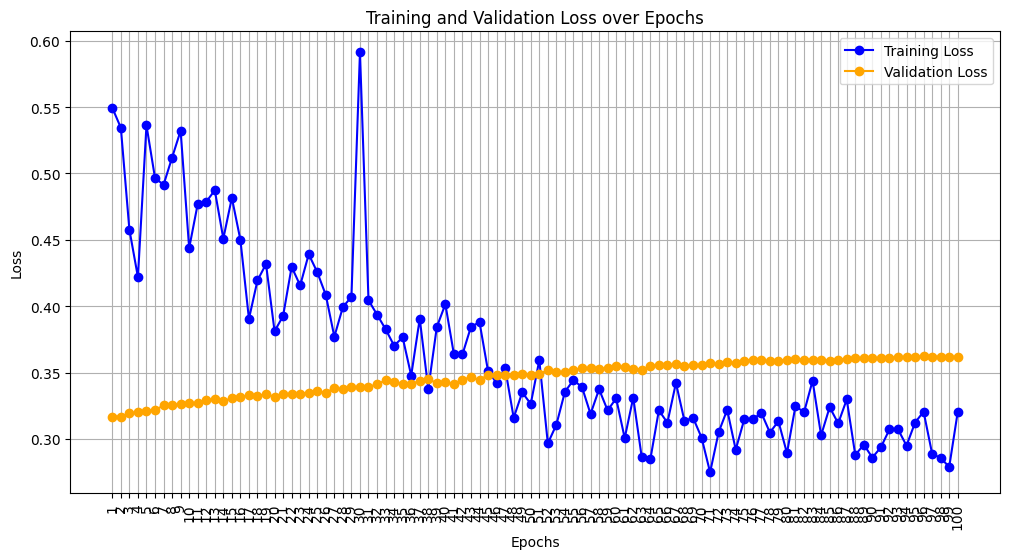

In [13]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 101))

# Training Loss values (100 values)
train_loss = [
    0.549400, 0.534400, 0.457700, 0.421900, 0.536200, 0.496600, 0.491400, 0.511900, 0.532200, 0.443700,
    0.476900, 0.478600, 0.487300, 0.450900, 0.481600, 0.449900, 0.390400, 0.419400, 0.431700, 0.381100,
    0.392600, 0.429600, 0.415600, 0.439100, 0.425600, 0.408400, 0.377000, 0.399300, 0.407000, 0.591200,
    0.404500, 0.393600, 0.382700, 0.370200, 0.376500, 0.347700, 0.390500, 0.337700, 0.384300, 0.401500,
    0.363800, 0.363600, 0.384500, 0.387900, 0.351000, 0.342200, 0.353300, 0.315900, 0.335000, 0.326400,
    0.359300, 0.296600, 0.310700, 0.335500, 0.344300, 0.339000, 0.318800, 0.337400, 0.321500, 0.330500,
    0.300600, 0.331100, 0.286000, 0.284500, 0.321500, 0.312200, 0.342200, 0.313500, 0.316000, 0.301000,
    0.274800, 0.305000, 0.321900, 0.291900, 0.314700, 0.314700, 0.319600, 0.304800, 0.313300, 0.289300,
    0.324800, 0.320000, 0.343800, 0.302700, 0.323900, 0.311700, 0.329700, 0.287900, 0.295700, 0.285900,
    0.293700, 0.307100, 0.307300, 0.294900, 0.312300, 0.320500, 0.288800, 0.285600, 0.278900, 0.320400
]

# Validation Loss values (99 values + added last value)
val_loss = [
    0.316840, 0.316844, 0.319209, 0.320108, 0.321120, 0.321733, 0.325170, 0.325433, 0.326397, 0.327324,
    0.326854, 0.329072, 0.330341, 0.328472, 0.330652, 0.331327, 0.332997, 0.332085, 0.333952, 0.331526,
    0.334008, 0.333535, 0.333886, 0.334951, 0.336069, 0.334811, 0.338114, 0.337371, 0.338915, 0.338877,
    0.338978, 0.341271, 0.344035, 0.343088, 0.341431, 0.341715, 0.343441, 0.345103, 0.342021, 0.343062,
    0.341111, 0.344706, 0.346503, 0.344426, 0.348144, 0.348220, 0.348159, 0.348224, 0.348603, 0.348019,
    0.349125, 0.351665, 0.350183, 0.350311, 0.351734, 0.353254, 0.353483, 0.352544, 0.353499, 0.355192,
    0.354059, 0.352703, 0.352267, 0.354843, 0.355705, 0.355505, 0.356320, 0.355256, 0.355373, 0.355578,
    0.356943, 0.356499, 0.357720, 0.357335, 0.359044, 0.359692, 0.359362, 0.358364, 0.358940, 0.359564,
    0.360008, 0.359755, 0.359744, 0.359503, 0.358998, 0.359791, 0.360385, 0.360942, 0.361040, 0.360964,
    0.360814, 0.361222, 0.361541, 0.361662, 0.361893, 0.362131, 0.361917, 0.361836, 0.361866, 0.361901
]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs, rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.legend()
plt.show()
